Christopher on small_img.zip



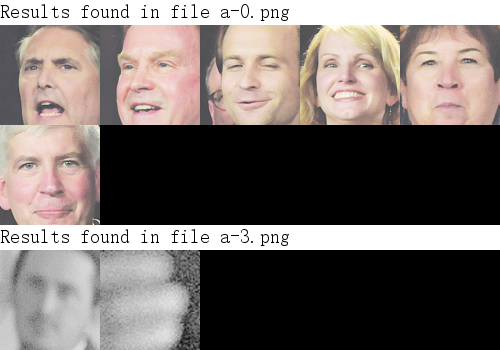

Mark on images.zip



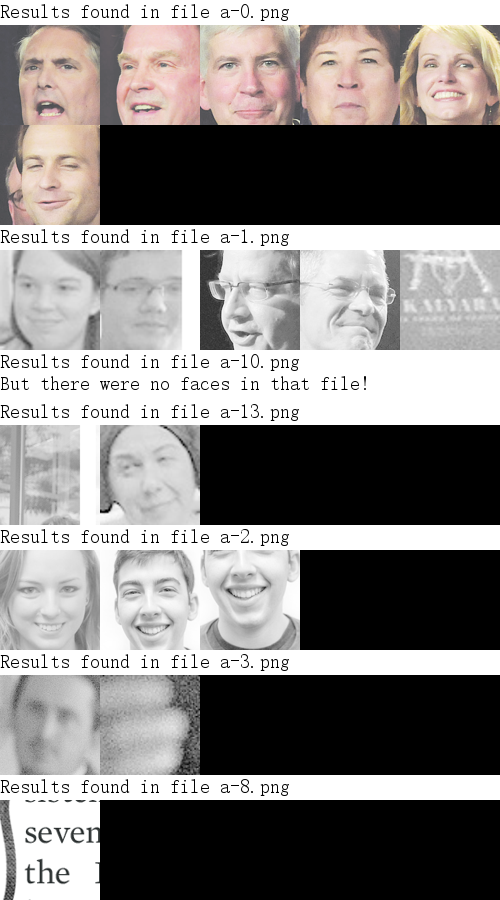

In [19]:
import cv2 as cv
import zipfile 
import numpy
import pytesseract
import math
from PIL import Image,ImageDraw,ImageFont

face_detect = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')

def getFaces(gray_image, pil_image):
    """Function that takes an image and returns a list of all the faces in it. 
    The function takes two arguments: a grayscale opencv image and a pil object of the same image"""
    all_faces = []
    faces = face_detect.detectMultiScale(gray_image, 1.35)
    for face in faces:
        cropped_img = pil_image.crop((face[0], face[1], face[0] + face[2], face[1] + face[3]))
        all_faces.append(cropped_img)
    return all_faces    

def getFilteredImages(image_objects, query_name):
    """Function that iterates through a dictionary of images and returns a list of those images that have the query_name string in it"""
    filtered_images = []
    for image in image_objects:
        text = pytesseract.image_to_string(image_objects[image]["pil_img"])
        if query_name in text:
            faces = getFaces(image_objects[image]["ocv_img"], image_objects[image]["pil_img"])
            if len(faces) == 0:
                filtered_images.append((image_objects[image]["name"], []))
            else:
                filtered_images.append((image_objects[image]["name"], faces))
    return filtered_images

def createContactSheet(zip_file ,query_name):
    """Function that creates a contact sheet of all the faces in those images that have the query_name string in them"""
    zipped_images = zipfile.ZipFile(zip_file) #open zipfile
    images_info_list = zipped_images.infolist() #get list of ZipInfo objects
    image_objects = {} #dictionary to hold imagename, pil image and, ocv image. 

    for i in range(len(images_info_list)):
        zip_img = zipped_images.open(images_info_list[i])
        pil_img = Image.open(zip_img)
        ocv_img = cv.cvtColor(numpy.array(pil_img), cv.COLOR_RGB2GRAY)
        image_objects["image_{}".format(i)] = {"name":images_info_list[i].filename, "pil_img":pil_img, "ocv_img":ocv_img}
        
    filtered_images = getFilteredImages(image_objects, query_name)
    
    sheet_width = 100*5
    sheet_height = 0
    
    for image in filtered_images:
        if len(image[1]) == 0:
            sheet_height += 50
        elif len(image[1]) > 5:
            sheet_height += 100 * math.ceil(len(image[1])/5) + 25
        else:
            sheet_height += 125
            
    contact_sheet = Image.new('RGB',(sheet_width,sheet_height), color = 'black')
    
    images_to_concat = []
    
    for image in filtered_images:
        if len(image[1]) == 0:
            rect_txt = Image.new('RGB', (500, 50), color = 'white')
            text_img = ImageDraw.Draw(rect_txt)
            text_img.text((0, 0), "Results found in file {}\nBut there were no faces in that file!".format(image[0]),font = ImageFont.truetype("simsun", size = 20) ,fill = "black")
            images_to_concat.append(rect_txt)
        elif len(image[1]) > 5:
            temp_sheet = Image.new('RGB', (500, 25 + 100 * math.ceil(len(image[1])/5)), color = 'black')
            rect_txt = Image.new('RGB', (500, 25), color = 'white')
            text_img = ImageDraw.Draw(rect_txt)
            text_img.text((0,0), "Results found in file {}".format(image[0]), font = ImageFont.truetype("simsun", size = 20) ,fill = "black")
            temp_sheet.paste(rect_txt, (0,0))
            x = 0
            y = 25
            for face in image[1]:
                rsz_face = face.resize((100, 100))
                temp_sheet.paste(rsz_face, (x, y))
                if x+100 == temp_sheet.width:
                    x=0
                    y=y+100
                else:
                    x=x+100
            images_to_concat.append(temp_sheet)
        else:
            temp_sheet = Image.new('RGB', (500, 125), color = 'black')
            rect_txt = Image.new('RGB', (500, 25), color = 'white')
            text_img = ImageDraw.Draw(rect_txt)
            text_img.text((0,0), "Results found in file {}".format(image[0]), font = ImageFont.truetype("simsun", size = 20) ,fill = "black")
            temp_sheet.paste(rect_txt, (0,0))
            x = 0
            y = 25
            for face in image[1]:
                rsz_face = face.resize((100, 100))
                temp_sheet.paste(rsz_face, (x, y))
                if x+100 == temp_sheet.width:
                    x=0
                    y=y+100
                else:
                    x=x+100
            images_to_concat.append(temp_sheet)
    
    j = 0
    k = 0
    #print(filtered_images)
    #print(images_to_concat)
    for i in images_to_concat:
        contact_sheet.paste(i, (j,k))
        k += i.height
    return contact_sheet


small_contact_sheet = createContactSheet('small_img.zip', 'Christopher')
big_contact_sheet = createContactSheet('images.zip', 'Mark')

print("Christopher on small_img.zip\n")
display(small_contact_sheet)
print("Mark on images.zip\n")
display(big_contact_sheet)